<a href="https://colab.research.google.com/github/mjavadf/whisper-small-fa/blob/main/whisper-small-fa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare

## Preparing the Environment for Speech Recognition

To set up the necessary environment for this speech recognition project, we'll begin by installing several key libraries:

1. **Hugging Face Datasets:** The [`datasets`]([https://huggingface.co/docs/datasets/en/index](https://huggingface.co/docs/datasets/en/index)) library provides streamlined access to a vast collection of datasets curated and hosted by Hugging Face. We'll leverage this library to easily download and preprocess the audio data and corresponding transcripts required for our model.

2. **Hugging Face Transformers:** The [`transformers`]([https://huggingface.co/docs/transformers/en/index](https://huggingface.co/docs/transformers/en/index)) library is a cornerstone of modern NLP, offering a wide array of pre-trained models for various tasks, including speech recognition. Crucially, we install `transformers` with the `[torch]` extra, ensuring compatibility with PyTorch—a popular deep learning framework upon which many of these models are built and optimized.

3. **Evaluation Metrics:** In addition to the core libraries for data handling and modeling, we also install `evaluate` and `jiwer`. The `evaluate` library simplifies the process of computing various metrics for evaluating model performance, while `jiwer` (Just In Time Word Error Rate) specifically focuses on calculating the Word Error Rate (WER), a common metric for assessing the accuracy of speech recognition models.


In [ ]:
%%capture
!pip install datasets
!pip install transformers[torch]
!pip install --upgrade evaluate jiwer

Accessing the full range of features provided by the Hugging Face libraries, including private repositories, necessitates authentication through a Hugging Face Hub access token. Users can create and manage these tokens via their account settings on the Hugging Face platform: https://huggingface.co/settings/tokens.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Dataset

For the purposes of this project, we will utilize the Persian portion of the [Common Voice 13](https://huggingface.co/datasets/mozilla-foundation/common_voice_13_0) dataset, which is a publicly available collection of transcribed speech data.


In [ ]:
%%capture
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()

common_voice["train"] = load_dataset(
    "mozilla-foundation/common_voice_13_0", "fa", split="train"
)
common_voice["test"] = load_dataset(
    "mozilla-foundation/common_voice_13_0", "fa", split="test"
)


In [ ]:
print(common_voice)

DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 28024
    })
    test: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 10440
    })
})


We'll focus on `audio` and `sentence` for fine-tuning, discarding other metadata in Common Voice 13.


In [ ]:
common_voice = common_voice.select_columns(["audio", "sentence"])
print(common_voice)

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 28024
    })
    test: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 10440
    })
})


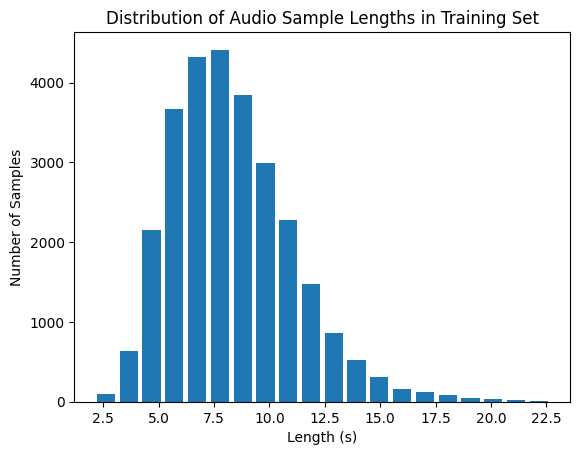

In [ ]:
import matplotlib.pyplot as plt
import librosa  # For audio processing

# Calculate lengths
lengths = [librosa.get_duration(y=x["audio"]["array"]) for x in common_voice["train"]]

# Plot histogram
plt.hist(lengths, bins=20, rwidth=0.8)
plt.xlabel("Length (s)")
plt.ylabel("Number of Samples")
plt.title("Distribution of Audio Sample Lengths in Training Set")
plt.show()

# Evaluation

In this step we will evaluate [`openai/whisper-small`](https://huggingface.co/openai/whisper-small) against transcribing persian speech. We'll evaluate the pre-trained Whisper model on the Common Voice 13 Persian test set, using the WER as a baseline to beat with our fine-tuned model later.

Load pre-trained Whisper model using `pipeline()`.

In [ ]:
from transformers import pipeline
import torch

if torch.cuda.is_available():
    device = "cuda:0"
    torch_dtype = torch.float16
else:
    device = "cpu"
    torch_dtype = torch.float32

pipe = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-small",
    torch_dtype=torch_dtype,
    device=device,
)

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

Evaluating on the whole dataset involves looping over audio inputs, using `KeyDataset` to select the "audio" column for the model. Save the outputs to a list. (13 mins on GPU w/ float16, ~12GB memory peak)

In [ ]:
from tqdm import tqdm
from transformers.pipelines.pt_utils import KeyDataset

all_predictions = []

# run streamed inference
for prediction in tqdm(
    pipe(
        KeyDataset(common_voice["test"], "audio"),
        max_new_tokens=128,
        generate_kwargs={"task": "transcribe", "language": "fa"},
        batch_size=32,
    ),
    total=len(common_voice["test"]),
):
    all_predictions.append(prediction["text"])

100%|██████████| 10440/10440 [17:43<00:00,  9.82it/s]


And finally, we can compute the WER. Let’s first compute the orthographic WER, i.e. the WER without any post-processing:

In [ ]:
from evaluate import load

wer_metric = load("wer")

wer_ortho = 100 * wer_metric.compute(
    references=common_voice["test"]["sentence"], predictions=all_predictions
)
wer_ortho

81.11997368637448

The initial Word Error Rate (WER) of 81% indicates that the model's current output requires significant improvement. This is not unexpected, as the model has not yet been tailored to the specific nuances of the Persian language.  Our next steps will focus on fine-tuning the model using the Persian training set, aiming to substantially reduce the WER and enhance the overall accuracy of speech recognition.

---

# Fine-tuning

The ASR pipeline consists of:

1. WhisperFeatureExtractor: Preprocesses raw audio to log-mel spectrograms.
2. Whisper model: Performs sequence-to-sequence mapping.
3. WhisperTokenizer: Post-processes predicted tokens to text.

For multilingual fine-tuning, set `"language"` (source audio language) and `"task"` ("transcribe" or "translate") when creating the processor. This ensures correct encoding of target labels.

To fine-tune Whisper on Farsi, set language to `"persian"` and task to `"transcribe"` when loading the processor.

In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small", language="persian", task="transcribe"
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Pre-Process the Data

Let's examine the dataset features, especially the `"audio"` column which specifies the sampling rate.

In [ ]:
common_voice["train"].features

{'audio': Audio(sampling_rate=48000, mono=True, decode=True, id=None),
 'sentence': Value(dtype='string', id=None)}

In [ ]:
from datasets import Audio

sampling_rate = processor.feature_extractor.sampling_rate
# resample audio
common_voice = common_voice.cast_column("audio", Audio(sampling_rate=sampling_rate))

To prepare data for the model, we'll define a function that:

1.  Loads and resamples audio on-the-fly using `sample["audio"]`.
2.  Computes log-mel spectrogram features using the feature extractor.
3.  Encodes transcriptions to label IDs using the tokenizer.


In [ ]:
def prepare_dataset(example):
  audio = example['audio']

  example = processor(
      audio=audio["array"],
        sampling_rate=audio["sampling_rate"],
        text=example["sentence"],
  )

  # compute input length of audio sample in seconds
  example["input_length"] = len(audio["array"]) / audio["sampling_rate"]

  return example

Apply the data preparation function to all training examples using `.map`, removing raw data columns and keeping only the preprocessed ones.

In [ ]:
common_voice = common_voice.map(
    prepare_dataset, remove_columns=common_voice.column_names["train"], num_proc=1
)

Map:   0%|          | 0/28024 [00:00<?, ? examples/s]

Map:   0%|          | 0/10440 [00:00<?, ? examples/s]

In [ ]:
# common_voice.save_to_disk("content/drive/mydrive/common")  # Choose a suitable path

Next we should filter audio samples longer than 30 seconds

In [ ]:
max_input_length = 30.0


def is_audio_in_length_range(length):
    return length < max_input_length

common_voice["train"] = common_voice["train"].filter(
    is_audio_in_length_range,
    input_columns=["input_length"],
)

Filter:   0%|          | 0/28024 [00:00<?, ? examples/s]

In [ ]:
common_voice["train"]

Dataset({
    features: ['input_features', 'labels', 'input_length'],
    num_rows: 28024
})

All samples were under 30s, but filtering is recommended for future use. Data is ready for fine-tuning Whisper! Let's move on to the next step.

## Training and Evaluation

We need to:

- Define a data collector to prepare PyTorch tensors.
- Specify evaluation metrics (WER).
- Load and configure a pre-trained checkpoint.
- Define training arguments for the Trainer.

After fine-tuning, we'll evaluate the model on the test data to verify its accuracy in transcribing Persian speech.

In [ ]:
# define data collector

import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
  processor: Any

  def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:

    # split inputs and labels since they have to be of different lengths and need different padding methods
    # first treat the audio inputs by simply returning torch tensors
    input_features = [
        {"input_features": feature["input_features"][0]} for feature in features
    ]
    batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

    # get the tokenized label sequences
    label_features = [{"input_ids": feature["labels"]} for feature in features]
    # pad the labels to max length
    labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

    # replace padding with -100 to ignore loss correctly
    labels = labels_batch["input_ids"].masked_fill(
        labels_batch.attention_mask.ne(1), -100
    )

    # if bos token is appended in previous tokenization step,
    # cut bos token here as it's append later anyways
    if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
        labels = labels[:, 1:]

    batch["labels"] = labels

    return batch


We can now initialise the data collator we’ve just defined:

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

Next, we'll define the evaluation metric: Word Error Rate (WER). We'll load it from 🤗 Evaluate.

In [ ]:
import evaluate

metric = evaluate.load("wer")

define the `compute_metrics` function that takes model predictions and returns the WER metric.

In [ ]:
from transformers.models.whisper.english_normalizer import BasicTextNormalizer
normalizer = BasicTextNormalizer()


def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # compute orthographic wer
    wer_ortho = 100 * metric.compute(predictions=pred_str, references=label_str)

    # compute normalised WER
    pred_str_norm = [normalizer(pred) for pred in pred_str]
    label_str_norm = [normalizer(label) for label in label_str]
    # filtering step to only evaluate the samples that correspond to non-zero references:
    pred_str_norm = [
        pred_str_norm[i] for i in range(len(pred_str_norm)) if len(label_str_norm[i]) > 0
    ]
    label_str_norm = [
        label_str_norm[i]
        for i in range(len(label_str_norm))
        if len(label_str_norm[i]) > 0
    ]

    wer = 100 * metric.compute(predictions=pred_str_norm, references=label_str_norm)

    return {"wer_ortho": wer_ortho, "wer": wer}

Now let’s load the pre-trained Whisper small checkpoint.

In [ ]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

we should set `use_cache=False` due to incompatibility with gradient checkpointing, and re-enable cache for faster inference.

In [ ]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(
    model.generate, language="persian", task="transcribe", use_cache=True
)

Finally, we define training parameters. We'll set the number of training steps to 500 for a noticeable WER improvement

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-fa",  # name on the HF Hub
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    lr_scheduler_type="constant_with_warmup",
    warmup_steps=50,
    max_steps=500,  # increase to 4000 if you have your own GPU or a Colab paid plan
    gradient_checkpointing=True,
    fp16=True,
    fp16_full_eval=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=500,
    eval_steps=500,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


We can forward the training arguments to the `Trainer` along with our model, dataset, data collator and `compute_metrics` function:

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

max_steps is given, it will override any value given in num_train_epochs


Then we can simply start the training

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Wer Ortho,Wer
500,0.260100,0.565519,53.587972,48.302715


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}
There were missing keys in the checkpoint model loaded: ['proj_out.weight'].


TrainOutput(global_step=500, training_loss=0.6132637510299682, metrics={'train_runtime': 7068.3073, 'train_samples_per_second': 1.132, 'train_steps_per_second': 0.071, 'total_flos': 2.30868320256e+18, 'train_loss': 0.6132637510299682, 'epoch': 0.2853881278538813})

In [ ]:
kwargs = {
    "dataset_tags": "mozilla-foundation/common_voice_13_0",
    "dataset": "Common Voice 13",
    "language": "fa",
    "model_name": "Whisper Small Farsi",
    "finetuned_from": "openai/whisper-small",
    "tasks": "automatic-speech-recognition",
    "output_dir":
}

In [ ]:
trainer.push_to_hub(**kwargs)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1716384730.187f5ae9eb6f.764.0:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/mjavadf/whisper-small-fa/commit/ff66e51dc5b4c7763d28803775efc4ab88546277', commit_message='End of training', commit_description='', oid='ff66e51dc5b4c7763d28803775efc4ab88546277', pr_url=None, pr_revision=None, pr_num=None)

The model is now available on the HuggingFace hub and can be accessed via this link:  
https://huggingface.co/mjavadf/whisper-small-fa

Also to test the model you can use this HuggingFace space:  
https://huggingface.co/spaces/mjavadf/whisper-small/

Please note:  Evaluations demonstrate a significant improvement in Word Error Rate (WER), but the overall score remains low. It's important to acknowledge that some errors can be attributed to the nature of Persian writing itself. For instance, the letter "S" can be represented in three different ways: "س", "ص", and "ث". Additionally, Persian punctuation differs slightly from other languages, with the comma (",") being reversed ("،").